In [2]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code_ver2')
import os
import time
import cv2
import tensorflow as tf
import numpy as np
import json
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
from helpers import m
from helpers.draw_utils import draw_label_on_alb_output, draw_label_on_keyrcnn_in
print(m.NUM_CLASSES_T6)

15


In [3]:
# Specify where the data is loaded and stored

data_path_load = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\labled data\\tank 7 data\\balanced_data'
data_path_store = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\labled data\\tank 7 data\\augmented_data'

In [4]:
# Create albumentations pipeline
from albumentations import Blur 
from albumentations.augmentations.blur.transforms import ZoomBlur

# augmentor_sr = alb.Compose([
#                         alb.augmentations.geometric.transforms.Perspective(p=0.5, scale=(0, 0.15), fit_output=False),
#                         alb.augmentations.crops.transforms.RandomCropFromBorders(crop_left=0.5, crop_right=0, crop_top=0.1, crop_bottom=0.1, always_apply=False, p=0.5),
#                         alb.augmentations.geometric.resize.Resize(height=68, width=122, p=1),

#                         alb.augmentations.transforms.RandomToneCurve(scale=1, always_apply=False, p=0.7),
#                         alb.augmentations.transforms.FancyPCA(p=0.4, alpha=6),
#                         ])

# augmentor_sl = alb.Compose([
#                         alb.augmentations.geometric.transforms.Perspective(p=0.5, scale=(0, 0.15), fit_output=False),
#                         alb.augmentations.crops.transforms.RandomCropFromBorders(crop_left=0, crop_right=0.5, crop_top=0.1, crop_bottom=0.1, always_apply=False, p=0.5),
#                         alb.augmentations.geometric.resize.Resize(height=68, width=122, p=1),

#                         alb.augmentations.transforms.RandomToneCurve(scale=1, always_apply=False, p=0.7),
#                         alb.augmentations.transforms.FancyPCA(p=0.4, alpha=6),
#                         ])


augmentor = alb.Compose([Blur(blur_limit=(1, 3), p=0.5),
                       alb.augmentations.transforms.RandomToneCurve (scale=0.1, always_apply=False, p=0.5),
                       alb.augmentations.geometric.transforms.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, normalized=False, always_apply=False, p=0.5),
                       alb.augmentations.dropout.coarse_dropout.CoarseDropout (max_holes=8, max_height=20, max_width=20, min_holes=2, min_height=5, min_width=5, fill_value=(120,120,120), mask_fill_value=None, always_apply=False, p=0.5),
                       alb.augmentations.transforms.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, p=0.8),
                       ])



[]

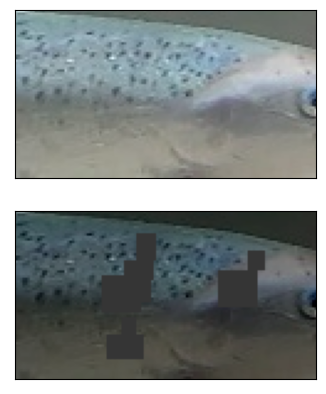

In [22]:
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.exposure import match_histograms, equalize_hist
import cv2

ex_img_name = '1'

# Load image and manual annotations from disk
img = cv2.imread(os.path.join(data_path_load, 'images', ex_img_name + '.jpeg'))

# Call augmentor
augmented = augmentor(image=img)

# Display image
fig, ax = plt.subplots(2,1)
ax[0].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(augmented['image'])
ax[1].set_xticks([])
ax[1].set_yticks([])


In [5]:
# Create augmented dataset, and save to disk
inflation_ratio = 30
for image in os.listdir(os.path.join(data_path_load, 'images')):
    # Read in image
    img = cv2.imread(os.path.join(data_path_load, 'images', image))

    #label = int(image.split('.')[0])
    # Read in label
    label_path = os.path.join(data_path_load,'labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
       with open(label_path, 'r') as f:
           label = json.load(f)
    try: 
        # Augment image inflation_ratio times, and save to disk. If an image has no labels, try to augment it again
        succ = 0
        for i in range(inflation_ratio):
            augmented = augmentor(image=img)
            #if label % 2 == 0:
            #    augmented = augmentor_sr(image=img)
            #else:
            #    augmented = augmentor_sl(image=img)
            cv2.imwrite(os.path.join(data_path_store, 'images', f'{image.split(".")[0]}.{i}.jpg'), augmented['image']) # Save image
            with open(os.path.join(data_path_store, 'labels', f'{image.split(".")[0]}.{i}.json'), 'w') as f: # Save label
                json.dump(label, f)
    except Exception as e:
        print(e)